The aim of this exercise is to assess the relationshipt between socio-demographic variables and the rate of physicians per 100k inhabitants at the US county-level and compare the performance of a linear regression versus lasso regression

# Imports

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pickle import dump, load
from sklearn.feature_selection import chi2 , SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, make_scorer, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

# Model estimation

The aim of this model is to assess the relationshipt between socio-demographic variables and the rate of physicians per 100k inhabitants at the county level.

To accomplish this task, first, I will estimate a linear regression **without** using feature selection and compare its performance with a lasso regression. Not using selectkbest() on this data is intentional to better compare the performance of linear vs lasso regression

In [19]:
#Loading data
X_train_sc=pd.read_csv('/workspaces/US-health-ML/data/interim/X_train_sc.csv') #Scaled
y_train=pd.read_csv("/workspaces/US-health-ML/data/interim/y_train.txt", header=None)

X_test_sc=pd.read_csv('/workspaces/US-health-ML/data/interim/X_test_sc.csv') #Scaled
y_test=pd.read_csv("/workspaces/US-health-ML/data/interim/y_test.txt", header=None)

## Linear regression

In [20]:
linreg=LinearRegression()
linreg.fit(X_train_sc, y_train)

LinearRegression()

### Evaluating model performance:

In [21]:
y_pred_sc=linreg.predict(X_test_sc)

According to the predicted model, the explanatory variables explain 100% of the variance in the number of Active Physicians per 100000 Population.

The root-mean squared error, on the training model, on average the model's predictions differ from the actual values by approximately 1.4 Physicians per 100000 Population.

Although once could argue the model did a great job predicting the test data, in this case, this number shows a problematic. As I pointed out earlier, the model suffers from imperfect multicollinearity.

Having high imperfect multicollinearity (e.g., high correlation among covariates) could lead to serious consecuences on the estimates such as: higher variance and model sensitivity to changes in the sample when generalising it to new data (e.g., low external validity).

High imperfect multicollinearity can lead to higher overfitting and to an **inflated** R-squared, mening that the independet variables falsely predict a higher percentage of the variance in the dependent variable. In reality, what occurs is that this falsely high explanatory power is due to correlated covariates.

In [22]:
print('R-squared: ', r2_score(y_test, y_pred_sc))
print('Root-Mean squared error: ', mean_squared_error(y_test, y_pred_sc, squared=False))

R-squared:  1.0
Root-Mean squared error:  1.4191833836093787e-13


To have an idea if there is overfitting I would now calculate the same two metrics for the train set and compare values for train versus test set:

Both metrics are quite similar, which suggest there may be no overfitting but keep in mind that high imperfect multicollinearity may affect the reliability of these metrics

In [23]:
y_pred_train=linreg.predict(X_train_sc)

print('R-squared: ', r2_score(y_train, y_pred_train))
print('Root-Mean squared error: ', mean_squared_error(y_train, y_pred_train, squared=False))

R-squared:  1.0
Root-Mean squared error:  1.3101300284834623e-13


Now, let's see what the estimated coefficients are using linear regression:

The graphs show that several of the coefficients are quite distant from zero, which is expectec since linear regression does not have a penalisation term such as lasso regression. On the lasso regression, the same graph will be replicated to see how much the estimated coefficients differ.



In [24]:
coef_matrix=pd.DataFrame(linreg.coef_.ravel(), columns=['coefs'])
coef_matrix['vars']=linreg.feature_names_in_

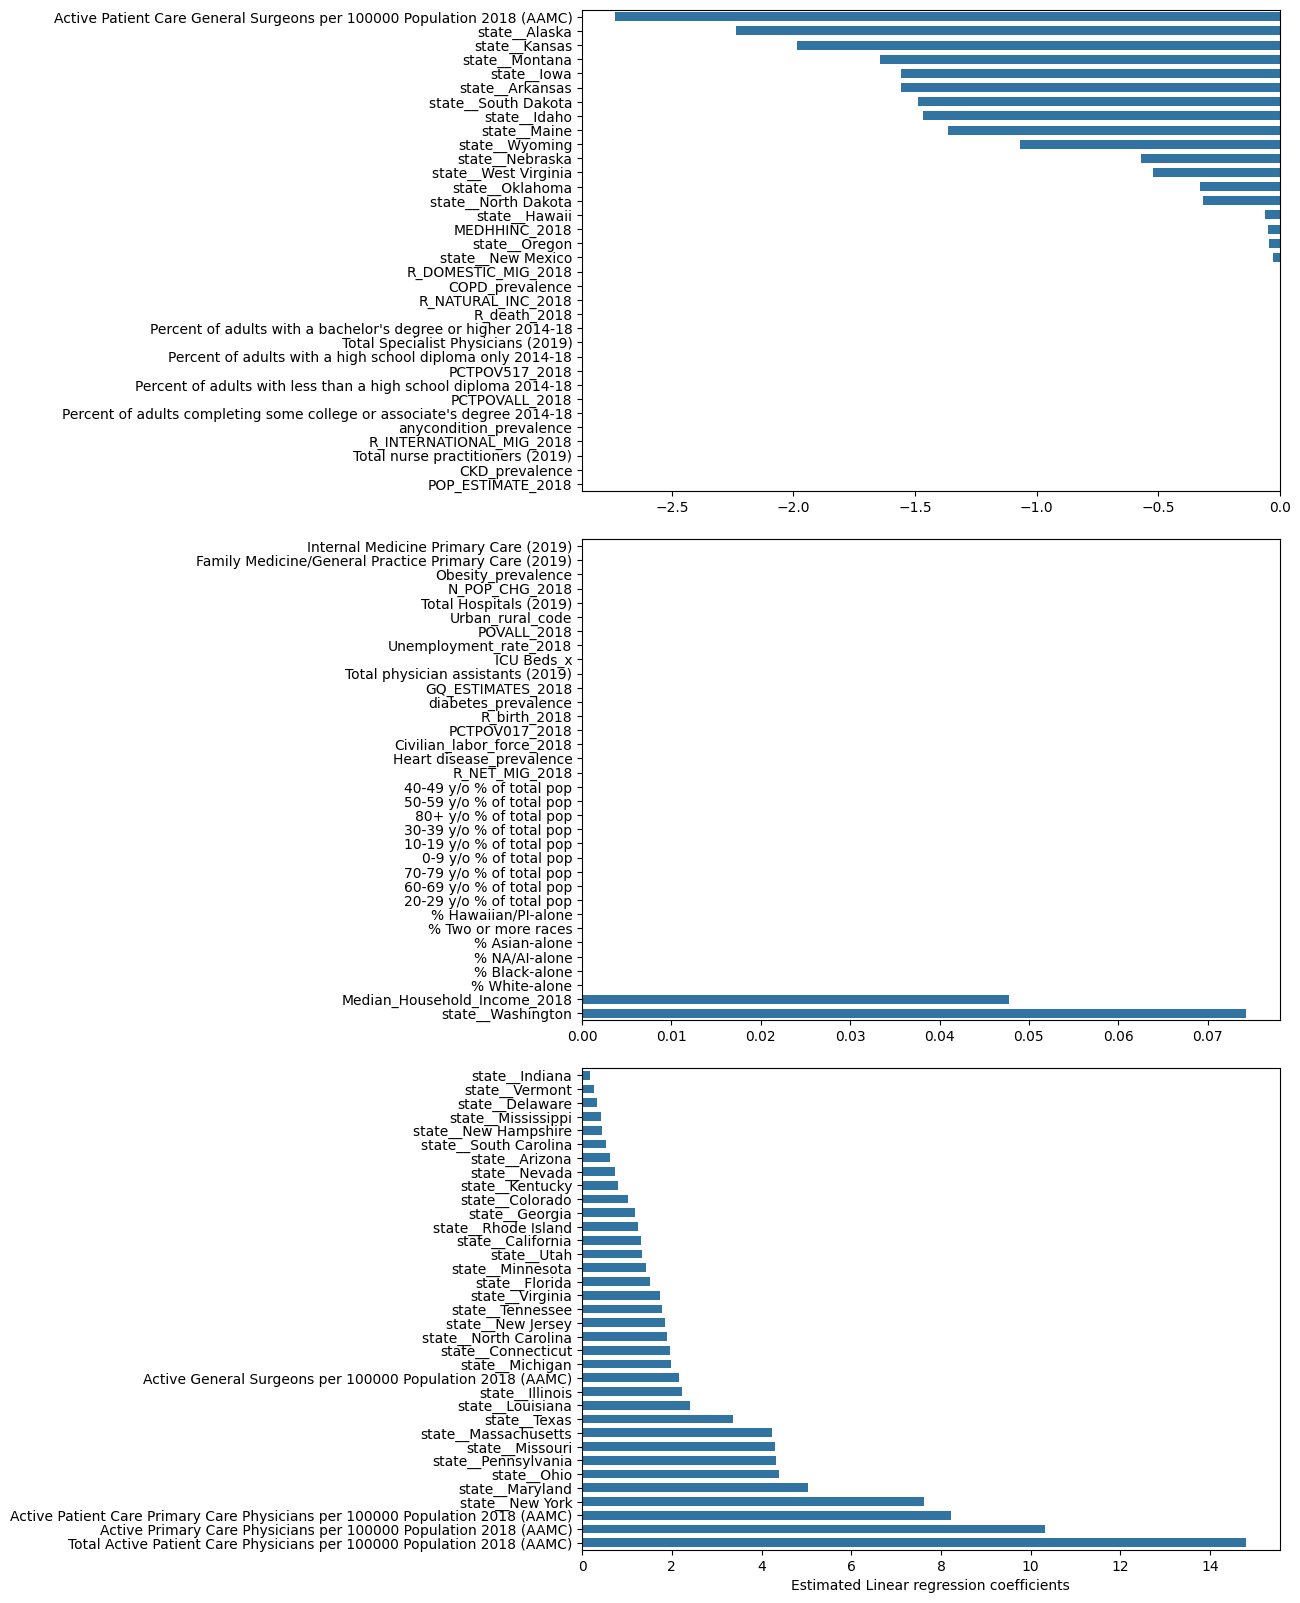

In [25]:
fig, ax=plt.subplots(3,1, figsize=(9,20))
sns.barplot(coef_matrix.sort_values('coefs', ascending=True).iloc[0:34], y='vars', x='coefs', ax=ax[0], orient="y",gap=0.2)
sns.barplot(coef_matrix.sort_values('coefs', ascending=True).iloc[35:69], y='vars', x='coefs', ax=ax[1], orient="y",gap=0.2)
sns.barplot(coef_matrix.sort_values('coefs', ascending=True).iloc[70:], y='vars', x='coefs', ax=ax[2], orient="y",gap=0.2)
plt.subplots_adjust(hspace=0.1)

for a in [0,1,2]:
    ax[a].set_ylabel('')
    ax[a].set_xlabel('')

ax[2].set_xlabel('Estimated Linear regression coefficients')
plt.show()

## Lasso Regression

The code below is hyperparameter optimization. I am trying to find the optimal alpha of the lasso regression. The grid search scores the model performance based on R-square and root-mean-square-error.

After fitting the model, I store the model performance metrics in a data frame as I will later use it to plot metrics

In [26]:
# alphas=np.linspace(0,20,80)

# metrics=pd.DataFrame(columns=['mean_train_R-Square','mean_train_Root-MSE'])

# for a in alphas:
#     lasso=Lasso(alpha=a)
#     lasso.fit(X_train_sc, y_train)
#     y_pred_lasso=lasso.predict(X_test_sc)
    
#     metrics.loc[len(metrics)]={
#         'mean_train_R-Square' : r2_score(y_test, y_pred_lasso),
#         'mean_train_Root-MSE': mean_squared_error(y_test, y_pred_lasso, squared=False)
#     }
# metrics['param_alpha']=alphas 

alphas={'alpha':np.linspace(0,20,40)}
lasso=Lasso()
score={'R-Square':'r2', 'Root-MSE': 'neg_root_mean_squared_error'}

#Train data
lasso_cv=GridSearchCV(lasso, alphas, scoring=score, refit=False) #setting refit=False as the aim is to see how the metrics change with alpha
lasso_cv.fit(X_train_sc, y_train)
metrics=pd.DataFrame(lasso_cv.cv_results_)

metrics['mean_test_Root-MSE']=-metrics['mean_test_Root-MSE']#gridsearch sets MSE with negative values by default
to_rename = {'mean_test_R-Square': 'mean_train_R-Square',
    'mean_test_Root-MSE': 'mean_train_Root-MSE',}

metrics.rename(columns=to_rename, inplace=True)# Rename the columns


/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/vscode/.local/lib/pyth

In [27]:
metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mean_fit_time         40 non-null     float64
 1   std_fit_time          40 non-null     float64
 2   mean_score_time       40 non-null     float64
 3   std_score_time        40 non-null     float64
 4   param_alpha           40 non-null     object 
 5   params                40 non-null     object 
 6   split0_test_R-Square  40 non-null     float64
 7   split1_test_R-Square  40 non-null     float64
 8   split2_test_R-Square  40 non-null     float64
 9   split3_test_R-Square  40 non-null     float64
 10  split4_test_R-Square  40 non-null     float64
 11  mean_train_R-Square   40 non-null     float64
 12  std_test_R-Square     40 non-null     float64
 13  rank_test_R-Square    40 non-null     int32  
 14  split0_test_Root-MSE  40 non-null     float64
 15  split1_test_Root-MSE  40 

Metrics performance plot:

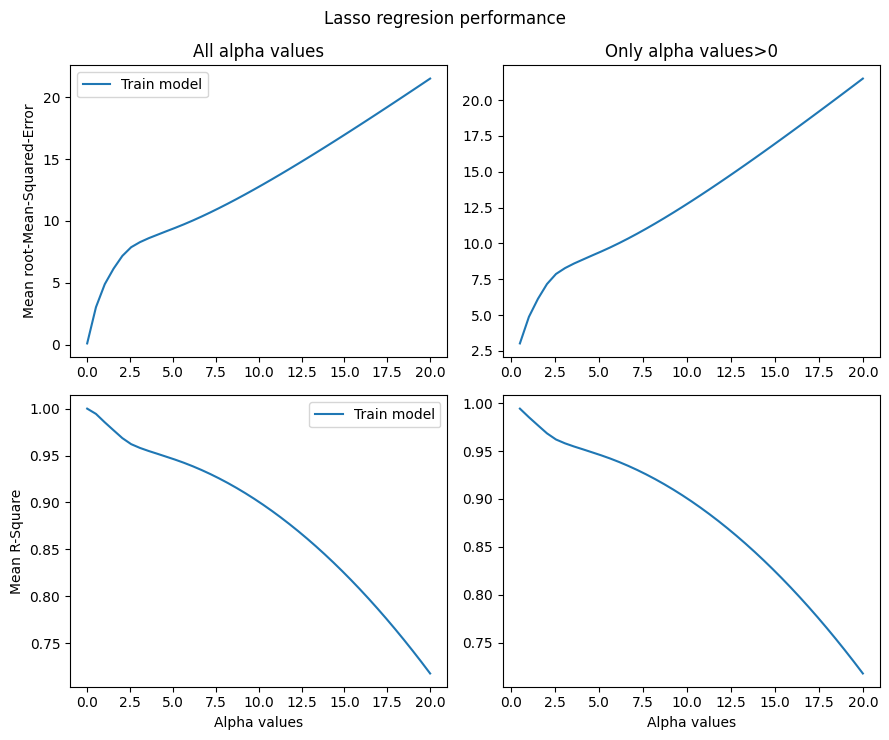

In [35]:
fig, ax = plt.subplots(2,2, figsize=(9,7.5))

ax[0,0].plot(metrics['param_alpha'], metrics['mean_train_Root-MSE'], label='Train model')
ax[0,0].set_ylabel('Mean root-Mean-Squared-Error')
ax[0,0].set_xlabel('')
ax[0,0].set_title('All alpha values')
ax[0,0].legend()

ctrain=metrics['param_alpha']>0

ax[0,1].plot(metrics[ctrain]['param_alpha'], metrics[ctrain]['mean_train_Root-MSE'])
ax[0,1].set_xlabel('')
ax[0,1].set_title('Only alpha values>0')

ax[1,0].plot(metrics['param_alpha'], metrics['mean_train_R-Square'], label='Train model')
ax[1,0].set_ylabel('Mean R-Square')
ax[1,0].set_xlabel('Alpha values')
ax[1,0].legend()

ax[1,1].plot(metrics[ctrain]['param_alpha'], metrics[ctrain]['mean_train_R-Square'])
ax[1,1].set_xlabel('Alpha values')


plt.suptitle('Lasso regresion performance')
plt.tight_layout()
plt.show()

Based on the left column, the lasso regression performs 'best' when alpha==0. However, when alpha==0 the objective function is equivalent to that of ordinary least squares. Therefore an alpha==0 does not solve the issues generated by high imperfect multicollinearity discussed on the linear regression section. 

For alpha values higher than 0, the model performance starts to decline on both metrics. One hand the R-square declines, while the root-MSE increases with higher alpha values. These results are expected given that lasso penalises irrelevant covariates, shrinking their coeeficients towards zero, which means that the higher the alpha, the more is the penalisation for having irrelevant covariates. Therefore, the R-square declines as the model uses less and less variables to explain the variation in the dependent variable. Similarly, a higher alpha is associated with a lower root-MSE since more and more features are shrinked towards zero and it will be more difficult for the model to predict the variation in the dependent variable, which in turn, leads to a higher error. 

One way to check whether the lasso regression is addressing the high multicollinearity would be to check the estimated coefficients of the highly collinear variables. If they are not close to zero, it would mean the model is not addressing this problem

### Best hyperparameters

Given the previous graphs, I exclude the alpha value of zero as it does not do any adjustment to the coefficients.

Below is the best hyperparameter where both ranking scores for Root-MSE and R-square is equal to 2, meaning that it is the second best alpha. The first one is alpha = 0, which is excluded.

In [29]:
print(metrics[ctrain][['param_alpha','rank_test_Root-MSE','rank_test_R-Square']].head())

best_alpha=metrics[metrics['rank_test_Root-MSE']==2][['param_alpha']]
best_alpha=float(best_alpha.iloc[0,0])


  param_alpha  rank_test_Root-MSE  rank_test_R-Square
1    0.512821                   2                   2
2    1.025641                   3                   3
3    1.538462                   4                   4
4    2.051282                   5                   5
5    2.564103                   6                   6


According to the lasso regression metrics, the explanatory variables now explain about 99% of the variation in the dependent variable. Also, compared to the linear regression, the root-MSE is higher. This result is expected since lasso shrinks irrelevant coefficients towards zero, which hinders the model capacity in capturing patters in the data, and therefore, model predictions tend to deviate more from true values, leading to a higher MSE. 

In [30]:
lasso=Lasso(alpha=best_alpha)
lasso.fit(X_train_sc, y_train)

y_pred_lasso=lasso.predict(X_test_sc)

print('R-squared: ', r2_score(y_pred_lasso,y_test))
print('Root-Mean squared error: ', mean_squared_error(y_test, y_pred_lasso, squared=False))
print(lasso.n_iter_)



R-squared:  0.9951677250346685
Root-Mean squared error:  2.8932266913014435
48


Now obtaining metrics for train set to compare them with test set: similar result to linear regression both metrics are similar

In [31]:
y_pred_train=lasso.predict(X_train_sc)

print('R-squared: ', r2_score(y_train, y_pred_train))
print('Root-Mean squared error: ', mean_squared_error(y_train, y_pred_train, squared=False))

R-squared:  0.9950101469555952
Root-Mean squared error:  2.8595148280319775


Now obtaining estimated coefficients of lasso regression:

The graphs below show how the lasso regression shrinked several of the collinear variables observed in the multivariate analysis such as: health conditions, number of physicians, nurses, as well as ICU beds and number of hospitals. 

In [32]:
coef_matrix=pd.DataFrame(lasso.coef_.ravel(), columns=['coefs'])
coef_matrix['vars']=lasso.feature_names_in_

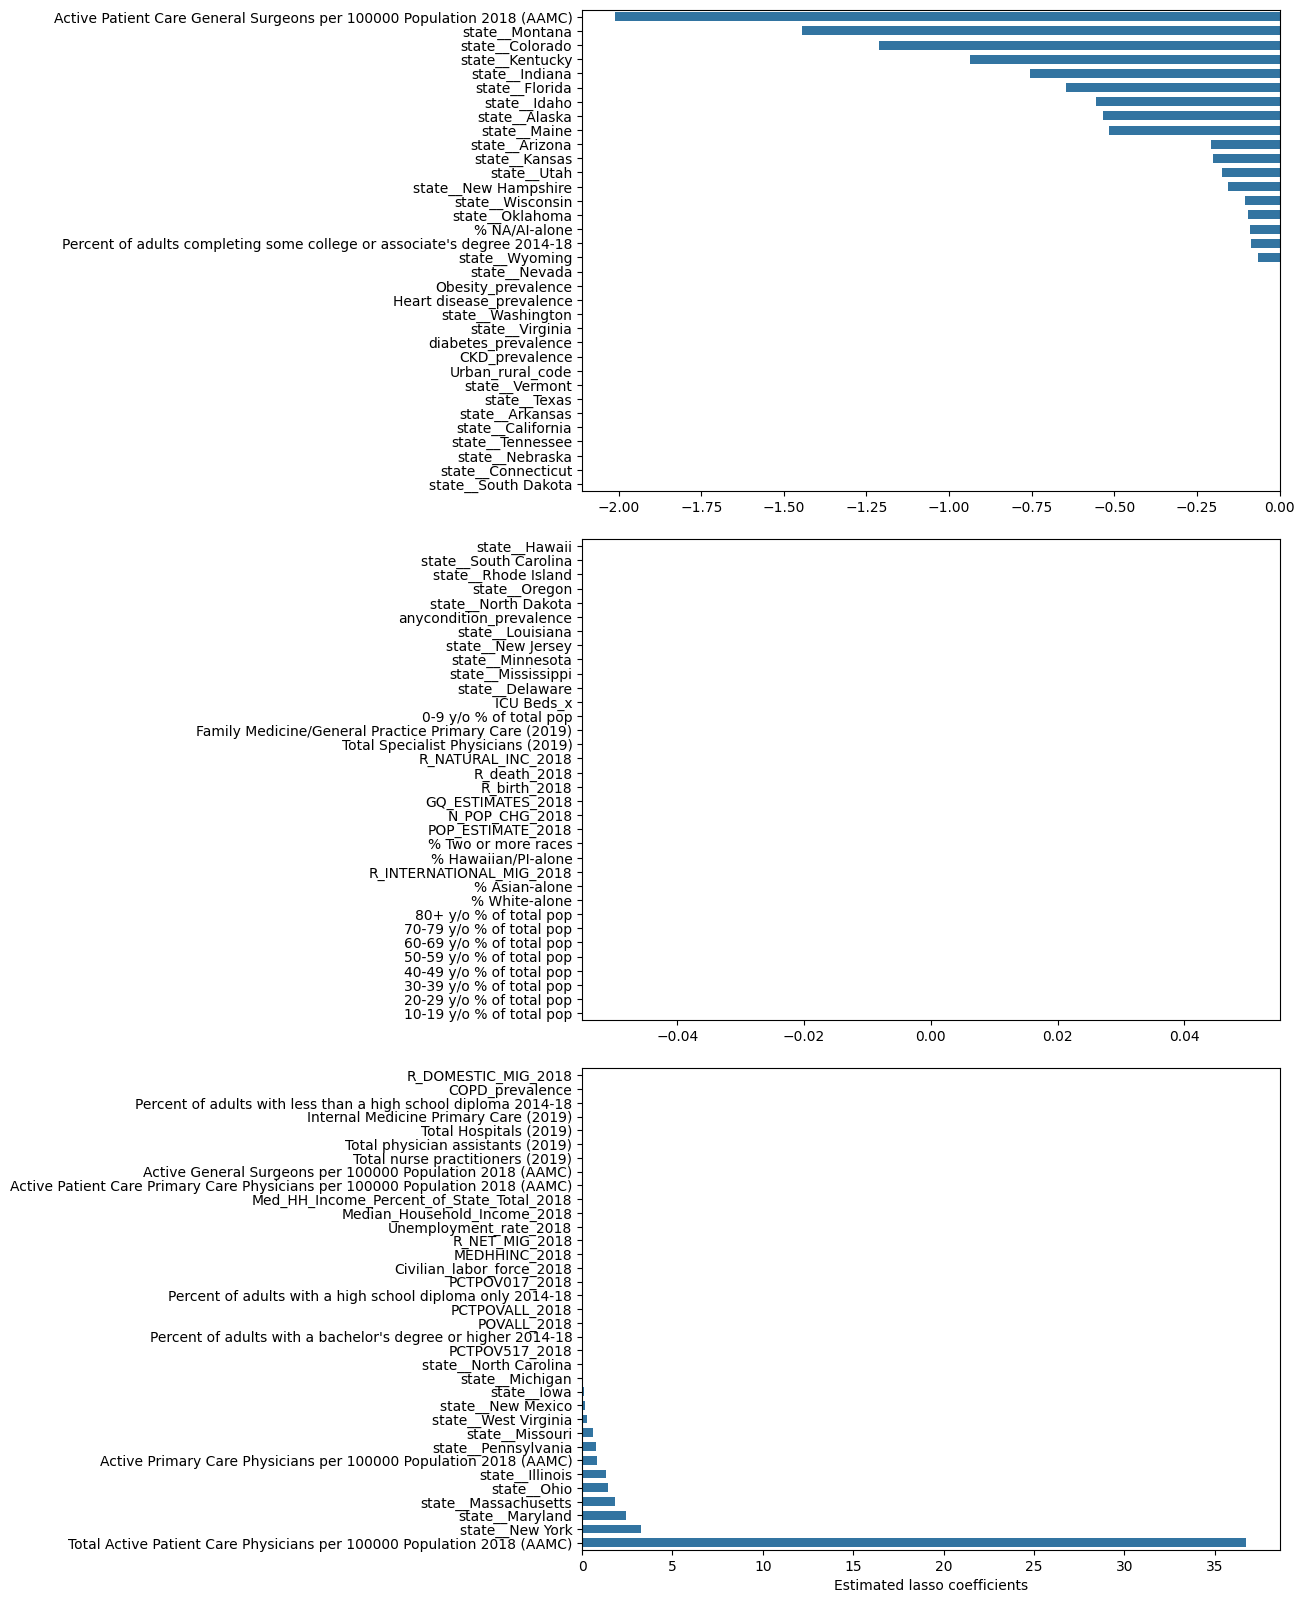

In [33]:
fig, ax=plt.subplots(3,1, figsize=(9,20))
sns.barplot(coef_matrix.sort_values('coefs', ascending=True).iloc[0:34], y='vars', x='coefs', ax=ax[0], orient="y",gap=0.2)
sns.barplot(coef_matrix.sort_values('coefs', ascending=True).iloc[35:69], y='vars', x='coefs', ax=ax[1], orient="y",gap=0.2)
sns.barplot(coef_matrix.sort_values('coefs', ascending=True).iloc[70:], y='vars', x='coefs', ax=ax[2], orient="y",gap=0.2)
plt.subplots_adjust(hspace=0.1)

for a in [0,1,2]:
    ax[a].set_ylabel('')
    ax[a].set_xlabel('')

ax[2].set_xlabel('Estimated lasso coefficients')
plt.show()